<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%208%20-%20RNNs/P8_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%208%20-%20RNNs/P8_RNNs.ipynb)

# Text generation with an RNN

In this notebook we will learn how to generate text with a Recurrent Neural Network.

We will work with a dataset of Shakespeare's writing from Andrej Karpathy's article [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). 

Given a sequence of characters from this data (for example "Shakespear"), we will train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

### Import the necessary modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  2.0.0+cu118


In [ ]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)

Using device: cuda


In [ ]:
try:
  from icecream import ic
except:
  !pip install icecream
  from icecream import ic

### Download the Shakespeare dataset

In [ ]:
! wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2023-05-08 09:16:33--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt.7’

shakespeare.txt.7   100%[===================>]   1.06M  2.45MB/s    in 0.4s    

2023-05-08 09:16:33 (2.45 MB/s) - ‘shakespeare.txt.7’ saved [1115394/1115394]



###  Create a dataset class

For training we need a dataset of (input, label) pairs. Where input and label are sequences of characters. At each time step the input is the current character and the label is the next character. For example:

```
input = ['S', 'h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r']
label = ['h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r', 'e']
 ```

Actually we will vectorize the characters to convert them into numerical values. 

```
input = [44, 7, 0, 10, 4, 18, 15, 4, 0, 17]
label = [7, 0, 10, 4, 18, 15, 4, 0, 17, 4]
```

where each integer value is a class label, and the number of classes is the number of unique characters in our training data (our vocabulary size).

In [ ]:
class DatasetFromTextFile():
    def __init__(self, filename, sequence_length):
        self.filename = filename
        self.sequence_length = sequence_length
        
        # The whole sequence of characters in the text file (including characters like the end of line character '\n', punctuation marks, etc.)
        self.chars = self.load_chars()
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indices as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indices as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indices = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        with open(self.filename) as fp:
            text = fp.read()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indices)-self.sequence_length, self.sequence_length):
            x.append(np.array(self.chars_indices[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indices[index+1:index+self.sequence_length+1]))
        
        return  torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y)).long()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < len(self.y))), "Dataset index out of range"
        return self.x[idx], self.y[idx]

Now we can use the [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html) and [`torch.utils.data.Dataloader`](https://pytorch.org/docs/stable/data.html) classes to create the PyTorch dataloader. Notice that the `TensorDataset` class allows us to easily create a PyTorch `Dataset` from numpy arrays `(inputs, labels)`.

In [ ]:
# Create the dataset
sequence_length = 100
ShakespeareDataset = DatasetFromTextFile('shakespeare.txt', sequence_length)

print(f'We have {ShakespeareDataset.x.shape[0]} input sequence samples of length {ShakespeareDataset.x.shape[1]} \
and {ShakespeareDataset.y.shape[0]} label sequences of length {ShakespeareDataset.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_loader = DataLoader(ShakespeareDataset, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 1115394 characters
Unique characters (vocabulary size): 65
We have 11153 input sequence samples of length 100 and 11153 label sequences of length 100


In [ ]:
len(next(iter(train_loader)))

2

## Build the model

Our model has three layers:

* `torch.nn.Embedding`: The input layer. A trainable lookup table that will map each character-ID (class ID) to a dense vector with `embedding_dim` dimensions;
* `torch.nn.GRU`: A type of RNN with `hidden_dim` units
* `torch.nn.Linear`: The output layer, with number of outputs as our vocabulary size (`len(dataset.uniq_chars)`). It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

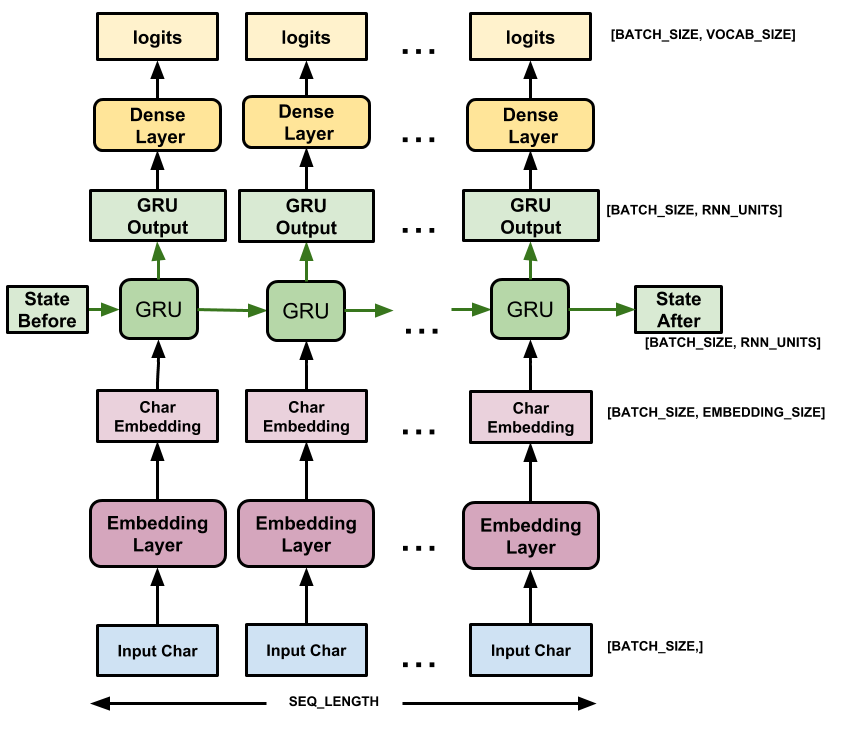

Image source: http://www.tensorflow.org

<span style="color:blue">
    
**Exercise 1:** Complete the code of the `Model` class. You need to embed your input using an `nn.Embedding` layer, create a GRU with `n_layers`, and then compute the output logits.
    
</span>

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(num_embeddings=input_dim,embedding_dim=embedding_dim) #input -> BATCH, SEQ_LENGHT (one-hot can reduce one dimension)  or -> BATCH, SEQ_LENGHT, INPUT DIM
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, dropout=drop_prob, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        self.fc = nn.Linear(hidden_dim,output_dim) # input -> BATCH, HIDDEN_DIM
        #out -> BATCH, OUTPUT_DIM (if one hot can reduce one dimension and we are only comparing integers, why can't we do BATCH, 1
         
        
    def forward(self, x, h):
        #ic(x.shape)
        emb = self.embedding(x)
        #ic(emb.shape)
        out, h = self.gru(emb, h)
        #ic(out.shape)
        out = self.fc(out)
        #ic(out.shape)
        return out, h
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

Now we can instantiate the model as follows:

In [ ]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model)

Model(
  (embedding): Embedding(65, 300)
  (gru): GRU(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


## Quick Experiment

Let's create a string and pass it through our model

In [ ]:
data = torch.tensor([ShakespeareDataset.char_to_index[w] for w in "Hello"])
print(data.shape)

torch.Size([5])


Our model expects a batch. We will create a batch of 1, using this one data point we have created

In [ ]:
data = data.unsqueeze(0) # this adds one more dimension (the batch one) to our data
print(data.shape)

torch.Size([1, 5])


Time to pass this through our model. To do so, we need to (1) move our data to the same device like the model and (2) initialise the state of our RNN

In [ ]:
data = data.to(device)
state = model.init_hidden(batch_size = 1) # remember that we will use just a single data point jere
state = state.to(device)
out, state = model(data, state) # The forward pass expects the current state as an argument, and returns the updated state in the output

print(out.shape)

torch.Size([1, 5, 65])


Our output returns 65 probability values for each character... We need to find which one is the maximum probability for each position, and convert it to the corresponding character

In [ ]:
_, idxs = torch.max(out[0], dim = 1)

print([ShakespeareDataset.index_to_char[int(c)] for c in idxs])

['t', 'P', 'q', 'e', 'e']


As expected both inputs and outputs have the same shape, and the predicted characters are just random since the model is not trained yet.

## Train the model

Training a language model is essentially a classification problem. Given the previous RNN state, and the input character at this time step, predict the class of the next character.

<span style="color:blue">

**Exercise 2:** which loss function do you think we shall use to train our model?
    
</span>

In [ ]:
def train(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion =  nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):

        for batch, (x, y) in enumerate(dataloader):
            state = model.init_hidden(batch_size) # Start with a new state in each batch            
            state = state.to(device)
            
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, state = model(x, state)
            #ic(y.shape)
            #ic(y_pred.shape)
            loss = criterion(y_pred.transpose(1, 2), y)  #cross entropy loss needs (N,C,seq_lenght)

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

Now train the model for 20 epochs and visualize the training loss curve.

In [ ]:
num_epochs = 20

losses = train(train_loader, model, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.16920280456543}
{'epoch': 0, 'batch': 30, 'loss': 2.2712533473968506}
{'epoch': 0, 'batch': 60, 'loss': 2.013389825820923}
{'epoch': 0, 'batch': 90, 'loss': 1.8290215730667114}
{'epoch': 0, 'batch': 120, 'loss': 1.6960813999176025}
{'epoch': 0, 'batch': 150, 'loss': 1.6662760972976685}
{'epoch': 1, 'batch': 0, 'loss': 1.635623812675476}
{'epoch': 1, 'batch': 30, 'loss': 1.5491881370544434}
{'epoch': 1, 'batch': 60, 'loss': 1.4998773336410522}
{'epoch': 1, 'batch': 90, 'loss': 1.4716861248016357}
{'epoch': 1, 'batch': 120, 'loss': 1.461719036102295}
{'epoch': 1, 'batch': 150, 'loss': 1.4352084398269653}
{'epoch': 2, 'batch': 0, 'loss': 1.4165855646133423}
{'epoch': 2, 'batch': 30, 'loss': 1.385844111442566}
{'epoch': 2, 'batch': 60, 'loss': 1.3765870332717896}
{'epoch': 2, 'batch': 90, 'loss': 1.3677911758422852}
{'epoch': 2, 'batch': 120, 'loss': 1.3627773523330688}
{'epoch': 2, 'batch': 150, 'loss': 1.3429627418518066}
{'epoch': 3, 'batch': 0, 'loss'

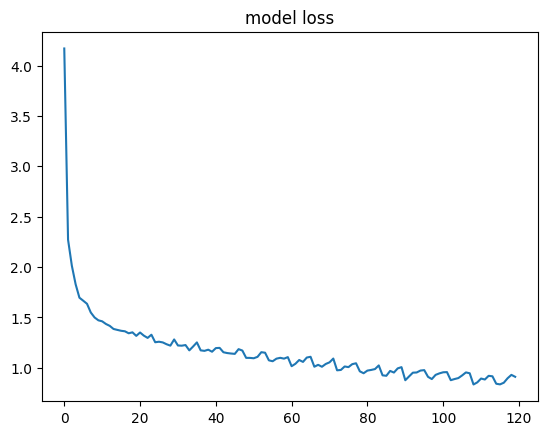

In [ ]:
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

## Try the trained model

Let's try again to predict some characters given the input sentence 'ROMEO:'. Now the predicted characters should be much better.

In [ ]:
with torch.no_grad():
    input_str = 'ROMEO:'

    state = model.init_hidden(batch_size=1)
    state = state.to(device)
    data = torch.tensor([[ShakespeareDataset.char_to_index[char] for char in input_str]]).to(device)
    output, state = model(data, state)

    _, predicted_idxs = torch.max(output[0], dim = 1)
    predicted_idxs = predicted_idxs.cpu().numpy()
    
    predicted_str = ''.join([ShakespeareDataset.index_to_char[idx] for idx in predicted_idxs])

    print(f'Input shape: {data.size()}')
    print(f'Output shape: {data.size()}')
    print(f'Input string: {input_str}')
    print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 6])
Output shape: torch.Size([1, 6])
Input string: ROMEO:
Output string: IMEO:



## Generate new text

In [ ]:
def predict(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]
    state = model.init_hidden(1)
    state = state.to(device)

    # we start by feeding all the input characters to our model
    x = torch.tensor([dataset.char_to_index[char] for char in chars])
    x = x.unsqueeze(0) # create a batch of 1
    x = x.to(device)

    for i in range(0, next_chars):
        
        y_pred, state = model(x, state)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)

    return chars

predicted = predict(ShakespeareDataset, model,'ROMEO:')
print(''.join(predicted))

ROMEO:
I am the mannock, but you were as ignorant;
Go thither; and with a purpose at
I be amed as in my steed, but not a month
After the tops-or what little of your high success!
Uncle, have I the Earl of Freeh
Loved and some poison than one count neglected.

GRUMIO:
O, doubtless this! I am bound to help him to your heart.

PETRUCHIO:
Why, though austill war with you; and it doth frame
Is thine own keeping: tell him, sir, how I may shake you,
Cry such as deep as writing a gentlewoman of our only
To send him still. This deadly chance,
He cannot give us him, one from scorn it,
He would laugh and rap the winners.

First Senator:
You were, peace, knees assured what we have I;
For, with my tent betwixt thee yet renown'd himself:
A ghostly father's burthen grow banish'd,
But such as have, for such God's sake, or they should they do interchange my wager enough:
What are they that brought forth this world
left this hour, hide five to beg, it says here
with a lurking tears are sleaped or groom 

While some of the sentences are grammatically correct, most do not make sense. The model has not learned the meaning of words (we would need a much larger corpus for that, and probably a word level language model), but consider the following:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text. Now it does a pretty decent job on spelling.

* The structure of the output resembles a play, blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* The model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

# Homework

<span style="color:blue">
    
**Exercise 3:** Build two new models: one using Simple RNN cells (torch.nn.RNN) instead of GRUs(torch.nn.RNN), and the other using LSTMs (torch.nn.LSTM). Train all three models (GRU, LSTM, SimpleRNN) for 30 epochs and compare the loss curves. You can optionally try different configurations: embedding dimension, hidden layers dimensions, number of layers, etc.
    
</span>

Simple RNN cells:

In [ ]:
class Model_sRNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model_sRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(num_embeddings=input_dim,embedding_dim=embedding_dim) #input -> BATCH, SEQ_LENGHT (one-hot can reduce one dimension)  or -> BATCH, SEQ_LENGHT, INPUT DIM
        self.gru = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, dropout=drop_prob, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        self.fc = nn.Linear(hidden_dim,output_dim) # input -> BATCH, HIDDEN_DIM
        #out -> BATCH, OUTPUT_DIM (if one hot can reduce one dimension and we are only comparing integers, why can't we do BATCH, 1
         
        
    def forward(self, x, h):
        #ic(x.shape)
        emb = self.embedding(x)
        #ic(emb.shape)
        out, h = self.gru(emb, h)
        #ic(out.shape)
        out = self.fc(out)
        #ic(out.shape)
        return out, h
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

In [ ]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model_sRNN = Model_sRNN(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model_sRNN)

Model_sRNN(
  (embedding): Embedding(65, 300)
  (gru): RNN(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


In [ ]:
losses_sRNN = train(train_loader, model_sRNN, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.195530891418457}
{'epoch': 0, 'batch': 30, 'loss': 2.2619833946228027}
{'epoch': 0, 'batch': 60, 'loss': 2.0200414657592773}
{'epoch': 0, 'batch': 90, 'loss': 1.8595860004425049}
{'epoch': 0, 'batch': 120, 'loss': 1.8276363611221313}
{'epoch': 0, 'batch': 150, 'loss': 1.758744478225708}
{'epoch': 1, 'batch': 0, 'loss': 1.6954327821731567}
{'epoch': 1, 'batch': 30, 'loss': 1.6794184446334839}
{'epoch': 1, 'batch': 60, 'loss': 1.6847586631774902}
{'epoch': 1, 'batch': 90, 'loss': 1.5946522951126099}
{'epoch': 1, 'batch': 120, 'loss': 1.6120141744613647}
{'epoch': 1, 'batch': 150, 'loss': 1.5524753332138062}
{'epoch': 2, 'batch': 0, 'loss': 1.5058420896530151}
{'epoch': 2, 'batch': 30, 'loss': 1.476167917251587}
{'epoch': 2, 'batch': 60, 'loss': 1.487998366355896}
{'epoch': 2, 'batch': 90, 'loss': 1.4610589742660522}
{'epoch': 2, 'batch': 120, 'loss': 1.5132817029953003}
{'epoch': 2, 'batch': 150, 'loss': 1.4665007591247559}
{'epoch': 3, 'batch': 0, 'los

LSTM cells

In [ ]:
class Model_LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(num_embeddings=input_dim,embedding_dim=embedding_dim) #input -> BATCH, SEQ_LENGHT (one-hot can reduce one dimension)  or -> BATCH, SEQ_LENGHT, INPUT DIM
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, dropout=drop_prob, batch_first=True) #input -> BATCH, SEQ_LENGHT, EMBEDDING_DIM
        self.fc = nn.Linear(hidden_dim,output_dim) # input -> BATCH, HIDDEN_DIM
        #out -> BATCH, OUTPUT_DIM (if one hot can reduce one dimension and we are only comparing integers, why can't we do BATCH, 1
         
        
    def forward(self, x, h ,c):
        #ic(x.shape)
        emb = self.embedding(x)
        #ic(emb.shape)
        out, (h,c) = self.lstm(emb, (h,c))
        #ic(out.shape)
        out = self.fc(out)
        #ic(out.shape)
        return out, h ,c
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        h = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        c = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return h, c

In [ ]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model_LSTM = Model_LSTM(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model_LSTM)

Model_LSTM(
  (embedding): Embedding(65, 300)
  (gru): LSTM(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


In [ ]:
def train_lstm(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion =  nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):

        for batch, (x, y) in enumerate(dataloader):
            h, c = model.init_hidden(batch_size) # Start with a new state in each batch            
            h = h.to(device)
            c = c.to(device)
            
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, h,c= model(x, h, c)
            #ic(y.shape)
            #ic(y_pred.shape)
            loss = criterion(y_pred.transpose(1, 2), y)  #cross entropy loss needs (N,C,seq_lenght)

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

In [ ]:
losses_LSTM = train_lstm(train_loader, model_LSTM , batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.1750593185424805}
{'epoch': 0, 'batch': 30, 'loss': 2.2920758724212646}
{'epoch': 0, 'batch': 60, 'loss': 1.9542357921600342}
{'epoch': 0, 'batch': 90, 'loss': 1.7968089580535889}
{'epoch': 0, 'batch': 120, 'loss': 1.6822433471679688}
{'epoch': 0, 'batch': 150, 'loss': 1.6040427684783936}
{'epoch': 1, 'batch': 0, 'loss': 1.5157350301742554}
{'epoch': 1, 'batch': 30, 'loss': 1.4901577234268188}
{'epoch': 1, 'batch': 60, 'loss': 1.4528248310089111}
{'epoch': 1, 'batch': 90, 'loss': 1.4734143018722534}
{'epoch': 1, 'batch': 120, 'loss': 1.4376825094223022}
{'epoch': 1, 'batch': 150, 'loss': 1.4157360792160034}
{'epoch': 2, 'batch': 0, 'loss': 1.331533670425415}
{'epoch': 2, 'batch': 30, 'loss': 1.366868495941162}
{'epoch': 2, 'batch': 60, 'loss': 1.3818844556808472}
{'epoch': 2, 'batch': 90, 'loss': 1.3548669815063477}
{'epoch': 2, 'batch': 120, 'loss': 1.3367136716842651}
{'epoch': 2, 'batch': 150, 'loss': 1.2966513633728027}
{'epoch': 3, 'batch': 0, 'l

Compare train curves

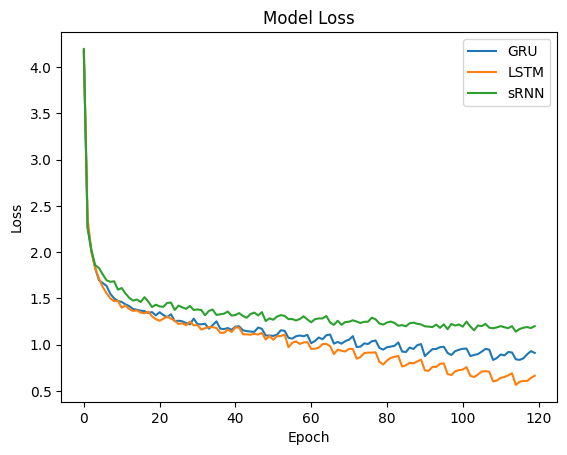

In [ ]:
# Visualize the loss evolution during training
plt.plot(losses, label='GRU')
plt.plot(losses_LSTM, label='LSTM')
plt.plot(losses_sRNN, label='sRNN')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

LSTM seems to have a much lower losss than GRU or simple RNN. Althought LSTM was much slower to train.

<span style="color:blue">

**Exercise 4:** Train your best model on a different dataset. Use the 'inaugural' corpus of the [NLTK](https://www.nltk.org/) library. Once trained generate some text with as we did for the model trained on the Shakespeare dataset. Compare the generated texts with both models using the smae "seed" (input) text. What differences do you appreciate? Why are they different?
    
</span>

The Natural Language Toolkit, or more commonly NLTK, is a suite of datasets, libraries and models for symbolic and statistical natural language processing (NLP). The Inaugural Address Corpus contains the US presidential inaugural addresses from 1789 to 2017. The following code loads the 'inaugural' corpus:

In [ ]:
import nltk
nltk.download('inaugural')

inaugural = nltk.corpus.inaugural
text = inaugural.raw()

print(f'Length of text: {len(text)} characters')

Length of text: 807276 characters


[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


create dataset

In [ ]:
class DatasetFromText():
    def __init__(self, txt, sequence_length):

        self.sequence_length = sequence_length
        
        # The whole sequence of characters in the text file (including characters like the end of line character '\n', punctuation marks, etc.)
        self.chars = txt
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indices as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indices as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indices = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indices)-self.sequence_length, self.sequence_length):
            x.append(np.array(self.chars_indices[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indices[index+1:index+self.sequence_length+1]))
        
        return  torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y)).long()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < len(self.y))), "Dataset index out of range"
        return self.x[idx], self.y[idx]

In [ ]:
sequence_length = 100
InauguralDataset = DatasetFromText(inaugural.raw(), sequence_length)

Unique characters (vocabulary size): 85


In [ ]:
batch_size = 64
train_loader_inaugural = DataLoader(InauguralDataset, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
#see a bit of the dataset 
InauguralDataset.chars[:1000]

'Fellow-Citizens of the Senate and of the House of Representatives:\n\nAmong the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the 14th day of the present month. On the one hand, I was summoned by my Country, whose voice I can never hear but with veneration and love, from a retreat which I had chosen with the fondest predilection, and, in my flattering hopes, with an immutable decision, as the asylum of my declining years -- a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination, and of frequent interruptions in my health to the gradual waste committed on it by time. On the other hand, the magnitude and difficulty of the trust to which the voice of my country called me, being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his qualifications, could not

Had some error and found the problem. Training one model on the inaugural dataset and looking for indexes in the shakespear dataset. Here we have the contrary example:

In [ ]:
onebactch_train_loader_inaugural = DataLoader(ShakespeareDataset, shuffle=True, batch_size=1, drop_last=True)
x, y = next(iter(onebactch_train_loader_inaugural))

In [ ]:
x_txt = [InauguralDataset.index_to_char[idx.item()] for idx in x.squeeze(0)]
y_txt = [InauguralDataset.index_to_char[idx.item()] for idx in y.squeeze(0)]
print("x_txt:")
print("".join(x_txt))
print("y_txt:")
print("".join(y_txt))

x_txt:
sbdea true Ducbfest nsc ,erenTea tie atntelWy tint hstebrhtm wihgi aioudc ,egofe-tplSot inThsb tie .
y_txt:
bdea true Ducbfest nsc ,erenTea tie atntelWy tint hstebrhtm wihgi aioudc ,egofe-tplSot inThsb tie .o


Train LSTN

In [ ]:
input_dim = len(InauguralDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(InauguralDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model_2 = Model_LSTM(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)
 
print(model_2)

Model_LSTM(
  (embedding): Embedding(85, 300)
  (gru): LSTM(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=85, bias=True)
)


In [ ]:
num_epochs = 20
losses_2 = train_lstm(train_loader_inaugural, model_2, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 0.9225517511367798}
{'epoch': 0, 'batch': 30, 'loss': 0.9505059123039246}
{'epoch': 0, 'batch': 60, 'loss': 0.9619765281677246}
{'epoch': 0, 'batch': 90, 'loss': 0.964988648891449}
{'epoch': 0, 'batch': 120, 'loss': 0.9475042223930359}
{'epoch': 1, 'batch': 0, 'loss': 0.9101590514183044}
{'epoch': 1, 'batch': 30, 'loss': 0.9002525806427002}
{'epoch': 1, 'batch': 60, 'loss': 0.9454083442687988}
{'epoch': 1, 'batch': 90, 'loss': 0.9190880060195923}
{'epoch': 1, 'batch': 120, 'loss': 0.9549928903579712}
{'epoch': 2, 'batch': 0, 'loss': 0.8886952996253967}
{'epoch': 2, 'batch': 30, 'loss': 0.8834405541419983}
{'epoch': 2, 'batch': 60, 'loss': 0.9089232683181763}
{'epoch': 2, 'batch': 90, 'loss': 0.9288163781166077}
{'epoch': 2, 'batch': 120, 'loss': 0.9341803789138794}
{'epoch': 3, 'batch': 0, 'loss': 0.8452488780021667}
{'epoch': 3, 'batch': 30, 'loss': 0.8485264778137207}
{'epoch': 3, 'batch': 60, 'loss': 0.8694499731063843}
{'epoch': 3, 'batch': 90, 'los

SHAKESPEAR DATSET:

In [ ]:
def predict_2(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]
    h, c = model.init_hidden(1)
    h = h.to(device)
    c = c.to(device)

    # we start by feeding all the input characters to our model
    x = torch.tensor([dataset.char_to_index[char] for char in chars])
    x = x.unsqueeze(0) # create a batch of 1
    x = x.to(device)

    for i in range(0, next_chars):
        
        y_pred, h, c = model(x, h, c)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)

    return chars


In [ ]:
predicted = predict_2(ShakespeareDataset, model_LSTM,'Today,')
print(''.join(predicted))

Today, brother.

HERTINGS:
I thank your worship.

MARCIUS:
They shall not live, whom I come there,
To make the tempted storm begins to fly.
And thou, the heed prove anger!

First Senator:
So much to Norfolk: I dare so send
them for the bitter fashion, that my unthrifty woman,
He is but seized, they hurried thy upright zeal.

iLBOWTHORY:
I thank you.
For here, my lord, forbear this land would tell thee.

LADY CAPUEET:
Talk not, mother.

ROMEO:
Indeed, she comes.
And most because the air with gentle lives in the
she-horn, whose charity well, whose state was mose
To catch the deputy, scarce came thence,
Some twenty offence but guilty words:
'Tis sign us out and such as isle,
That I disdain'd the worst: he's a lance's youth,
Mark'd not thy unrest in great desire
Nor her: the day is nothing; look to see, and love't,
It shall be so for blind to landers.
Ah, holy friar, these longer liver may move,
Some mean part to the senate-house and
The thoughts from thoughts of all thy suit;
And when the

INAUGURAL DATASET:

In [ ]:
predicted = predict_2(InauguralDataset, model_2,'Today,')
print(''.join(predicted))

Today, 1787, will helcomes the history of the supervision of the Constitution. We have translated us or corrupting and too, each of my family and daily live. The policy of stagnation and rapid system bearing negotiate by that will and cooperation from education as well. And we will be a case of affectivity.

To ourselve all parties, justice which the duties to gember claims with them for discussion inevitably work against the science of the American Union," what calls the Federal Government, to other nations, opponent, and together. We have been so long, and in my own. The principles and assurance reparaticly for the spot--artile society we have heretofore people overburdened in the suffrage Yet he has not complete. Its democracy have a silence day toil habits about no aid in their position of a common engreated institutions must be most aided by a contest cannot in dangerous instruction system based, and this technology that can this is sacredly necessary to refer upon the sturm other

We can conclude that one model copies very well the style of writing of the given dataset. Thus from the same "seed" seeing so different results.